### Install Packages

First, we begin from loading packages.

In [1]:
library(grid)
library(lattice) 
library(statmod)

To access the overall package documentation, type

In [2]:
#library(ChainLadder)

In [3]:
#demo(package="ChainLadder")

In [4]:
#vignette('ChainLadder', package='ChainLadder')

### Development Triangle

Reading the given dataset into R.

In [5]:
rawdata <- read.csv("datasets/ppauto_pos.csv")
tail(rawdata)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_B,CumPaidLoss_B,BulkLoss_B,EarnedPremDIR_B,EarnedPremCeded_B,EarnedPremNet_B,Single,PostedReserve97_B
14595,43494,American Hallmark Ins Co Of TX,1997,2001,5,5587,5537,0,32271,22646,9625,1,4527
14596,43494,American Hallmark Ins Co Of TX,1997,2002,6,5588,5549,0,32271,22646,9625,1,4527
14597,43494,American Hallmark Ins Co Of TX,1997,2003,7,5571,5567,0,32271,22646,9625,1,4527
14598,43494,American Hallmark Ins Co Of TX,1997,2004,8,5577,5577,0,32271,22646,9625,1,4527
14599,43494,American Hallmark Ins Co Of TX,1997,2005,9,5576,5576,0,32271,22646,9625,1,4527
14600,43494,American Hallmark Ins Co Of TX,1997,2006,10,5573,5576,-3,32271,22646,9625,1,4527


Instead of having the data separated by insurance company, we will sum the data subsets of the cumulative paid losses; then we will arrange the information by accident year and development lag.

In [6]:
.allisnumeric <- function (x, what = c("test", "vector"), extras = c(".", "NA")){
    
  # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  what <- match.arg(what)
  x <- sub("[[:space:]]+$", "", x)
  x <- sub("^[[:space:]]+", "", x)
  #xs <- x[x %nin% c("", extras)]
  xs <- x[match(x, extras, nomatch = 0) == 0]
  isnum <- suppressWarnings(!any(is.na(as.numeric(xs))))
  if (what == "test")
    isnum
  else if (isnum)
    as.numeric(x)
  else x
}

In [7]:
incr2cum <- function(Triangle, na.rm=FALSE){
    
  if(na.rm){
    upper <- col(Triangle) <= ncol(Triangle) + 1 - row(Triangle)
    upperna <- which(is.na(Triangle[upper]), arr.ind=TRUE)
    Triangle[upper][upperna] <- 0
  }
  cum <- t(apply(Triangle,1, cumsum))
  dimnames(cum) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(cum,"exposure") <- expos
  class(cum) <- c("triangle", "matrix")
  cum
}

In [8]:
cum2incr <- function(Triangle){
  incr <- cbind(Triangle[,1], t(apply(Triangle,1,diff)))
  dimnames(incr) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(incr,"exposure") <- expos
  class(incr) <- c("triangle", "matrix")
  incr
}

In [9]:
as.triangle <- function(Triangle, origin="origin", dev="dev", value="value",...){
  UseMethod("as.triangle")
}

In [10]:
as.triangle.matrix <- function(Triangle, origin="origin", dev="dev", value="value",...){
    
  class(Triangle) <- c("triangle", "matrix")
  if(is.null(dimnames(Triangle))){
    dimnames(Triangle) <- list(origin=1:nrow(Triangle), dev=1:ncol(Triangle))
  }
  names(dimnames(Triangle)) <- c(origin, dev)

  if(is.null(dimnames(Triangle)[[origin]])){
    dimnames(Triangle)[[origin]] <- 1:nrow(Triangle)
  }
  if(is.null(dimnames(Triangle)[[dev]])){
    dimnames(Triangle)[[dev]] <- 1:ncol(Triangle)
  }
  storage.mode(Triangle) <- "double"
  return(Triangle)
}

In [11]:
as.triangle.data.frame <- function(Triangle, origin="origin", dev="dev", value="value", ...){
  
  # aggregate claims data
  aggTriangle <- stats::aggregate(Triangle[[value]], list(Triangle[[dev]], Triangle[[origin]]), sum)
  names(aggTriangle) <- c(dev, origin, value)
  origin_names <- as.character(unique(aggTriangle[, origin]))
  dev_names <-  as.character(unique(aggTriangle[, dev]))
  
  # reshape into wide format
  tria <- stats::reshape(aggTriangle, 
                  v.names=value, 
                  timevar = dev, 
                  idvar = origin, 
                  direction = "wide", 
                  new.row.names = origin_names)[, -1]
  
  matrixTriangle <- as.matrix(tria)
  names(dimnames(matrixTriangle)) <- c(origin, dev)
  dimnames(matrixTriangle)[[1]] <- origin_names
  dimnames(matrixTriangle)[[2]] <- dev_names
  matrixTriangle <- matrixTriangle[order(nchar(origin_names), origin_names), order(nchar(dev_names), dev_names)]
  class(matrixTriangle) <- c("triangle", "matrix")
  return(matrixTriangle)
}

In [12]:
triangle <- function(..., bycol = FALSE, origin = "origin", dev = "dev", value = "value"){
    
  x <- list(...)
  if (length(x) == 1L) {
    ## 'len' contains the number of development periods (when filling by row) or origin periods (when filling by column). In the case
    ## where there is only one vector of data provided, 'len' is the positive root of n(n + 1)/2 = k, where k is the number of data
    ## points.
    len <- (-1 + sqrt(1 + 8 * length(x[[1L]])))/2
    ## Error if 'len' is not an integer, otherwise it is just too complicated to try infer what user wants. (Test taken from ?is.integer.)
    if (abs(len - round(len)) > .Machine$double.eps^0.5)
        stop("invalid number of data points for a triangle")
    ## Rearrange the data vector in a list of vectors suitable to build a 'len x len' triangle.
    s <- seq_len(len)                   # avoid generating twice
    x <- split(x[[1L]], rep(s, rev(s)))
  } else {
    ## If more than one data vector is provided in argument, the number of development or origin periods is derived from the
    ## *first* vector (this avoids looking at the length of each and every element to find the maximum).
    len <- length(x[[1L]])
  }
  ## Extend each data vector to length 'len' by filling with NAs and put into matrix form at the same time; dimension names will be in
  ## place thanks to 'sapply'.
  x <- sapply(x, function(x) { length(x) <- len; x })
  ## Turn to 'as.triangle' to complete the work.
  as.triangle.matrix(if (bycol) x else t(x), origin = origin, dev = dev, value = value)
}

In [13]:
as.data.frame.triangle <- function(x, row.names=NULL, optional, lob=NULL, na.rm=FALSE,...){

  longTriangle <- .as.LongTriangle(x, na.rm)
  if(is.null(row.names))
    rownames(longTriangle) <- paste(longTriangle[,1], longTriangle[,2], sep="-")
  if(!is.null(lob))
    longTriangle$lob=lob

  class(longTriangle) <- c("long.triangle", "data.frame")
  return(longTriangle)
}

plot.triangle <- function(x,type="b", xlab="dev. period", ylab=NULL, lattice=FALSE,...){
  .x <- x
  class(.x) <- "matrix"
  if(!lattice){
    matplot(t(.x),type=type, xlab=xlab, ylab=ifelse(is.null(ylab), deparse(substitute(x)), ylab),...)
  }else{
    df <- as.data.frame(as.triangle(.x)) 
    xyplot(value ~ dev | factor(origin), data=df, type=type, as.table=TRUE, xlab=xlab, ylab=ylab, ...)
  }
}

In [14]:
print.triangle <- function(x, ...) {
  ret <- x
  class(x) <- tail(class(x), -1)
  NextMethod(x, ...)
  invisible(ret)
}

In [15]:
.as.MatrixTriangle <- function(x, origin="origin", dev="dev", value="value"){
    
  ## x has to be a data.frame with columns: origin, dev and value
  x <- x[,c(origin, dev, value)]
  names(x) <- c("origin", "dev", "value")
  z <- reshape(x, timevar="dev", v.names="value", idvar="origin", direction="wide")
  z <- z[order(z$origin), ]

  .origin.names <- z$origin
  z <- z[,-1]
  names(z) <- gsub("value.", "",names(z))
  .dev.names <- as.numeric(as.character(names(z)))
  z <- z[,order(.dev.names)]

  z<- as.matrix(z)
  dimnames(z) <- list(origin=.origin.names, dev=sort(.dev.names))
  names(dimnames(z)) <- c(origin, dev)
  return(z)
}

In [16]:
as.LongTriangle <- function (Triangle, varnames = names(dimnames(Triangle)), value.name = "value", na.rm = TRUE) {
    
  if (!inherits(Triangle, "matrix")) stop("asLongTriangle only works for matrices")
  if (is.null(varnames)) varnames <- c("origin", "dev")
  else {
    if (is.na(varnames[1L])) varnames[1L] <- "origin"
    if (is.na(varnames[2L])) varnames[2L] <- "dev"
  }
  namecols <- setNames(expand.grid(dimnames(Triangle), KEEP.OUT.ATTRS = FALSE, stringsAsFactors = TRUE), varnames)
  if (na.rm) {
    isna <- is.na(Triangle)
    namecols <- namecols[!isna,]
    Triangle <- Triangle[!isna]
  }
  y <- cbind(namecols, setNames(data.frame(c(Triangle)), value.name))
  y
}

In [17]:
.as.LongTriangle <- function(Triangle, na.rm=FALSE){
    
  x <- Triangle
  nms <- names(dimnames(x))
  .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  .origin <- dimnames(x)[[nms[1L]]]
  if(class(dimnames(x)[[nms[2L]]]) %in% "character"){
    if(.allisnumeric(dimnames(x)[[nms[2L]]])){
      .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
    }else{
      .dev <- seq(along=(dimnames(x)[[nms[2L]]]))
      warning(paste(
        c("Development period was a character and has been set to:\n",.dev),
        collapse = " "))
    }
  }else{
    .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  }
  lx <- expand.grid(origin=.origin, dev=.dev, stringsAsFactors = FALSE)
  lx$value <- as.vector(x)
  if(na.rm){
    lx <- na.omit(lx)
  }
  if (!is.null(nms)) {
    if (!is.na(nms[1L])) names(lx)[1L] <- nms[1L]
    if (!is.na(nms[2L])) names(lx)[2L] <- nms[2L]
  }
  return(lx)
}

In [18]:
# A coefficients method to quickly pull out the factors from a ChainLadder model
coef.ChainLadder <- function(object, ...) {
  structure(sapply(object$Models, coefficients), names = head(colnames(object$Triangle), -1), ...)
}

In [19]:
getLatestCumulative <- function (Triangle, na.values = NULL) {
  # Returns the "current diagonal" from a triangle. This is defined to be the vector of entries from the triangle corresponding 
  # to the rightmost non-missing cell per row.
  # Features: 
  # 1. For the "lazy actuary" who leaves zeroes in triangle cells corresponding to future observations, can specify 
  #     na.values=0 to find the rightmost non-zero and non-NA entry.
  # 2. Assigns a "latestcol" attribute that gives the column index of the rightmost entry per row.
  # 3. Adorns the returned vector with 'names' corresponding to the rownames of the triangle, if available, and with a 'rowsname' 
  #    attribute holding the name of the row dimension of the matrix (e.g., 'origin' or 'ay'), if available.
  # 4. Assigns a 'colnames' attribute holding the column names of the matrix, if available, and with a "colsname" attribute holding 
  #    the name of the column dimension of the matrix  (e.g., 'dev' or 'age'), if available.
  #    The attributes assigned in 3 & 4 can be useful when the current diagonal is utilized in a method that may be unrelated to 
  #    the given Triangle but that relies on the origin and development age of the observations in the diagonal.
  
  if (!is.matrix(Triangle)) stop("Triangle '", 
      deparse(substitute(Triangle)), "' must be a matrix")
  # Define a function that, depending on the value of na.values, finds the rightmost column per row.
  f <- if (is.null(na.values)) function(x) ifelse(length(w <- which(!is.na(x))) > 0L, tail(w, 1L), 1) else function(x) ifelse(length(w <- which(!is.na(x) & !(x %in% na.values))) > 0L, tail(w, 1L), 1)
  # Apply that function to each row.
  latestcol <- apply(Triangle, 1L, f)
  # Select the rightmost values
  latestdiag <- Triangle[cbind(seq_along(latestcol), latestcol)]
  # Set attributes ...
  attr(latestdiag, "latestcol") <- latestcol
  # Set names and colnames attributes
  nms <- names(dmnms <- dimnames(Triangle))
  nms1 <- nms[1L]
  nms2 <- nms[2L]
  if (!is.null(dmnms[[1L]])) { # 'rownames' are available
    names(latestdiag) <- dmnms[[1L]]
    # save the name of the row dimension
    attr(latestdiag, "rowsname") <- nms1
    }
  if (!is.null(dmnms[[2L]])) { # 'colnames' are available
    attr(latestdiag, "colnames") <- dmnms[[2L]][latestcol]
    # save the name of the column dimension
    attr(latestdiag, "colsname") <- nms2
    }
  return(latestdiag)
  }

To make it to be a loss triangle, we will exclude any developments after 1997 in the dataset; then we will use the function, as.triangle, to organize the data into triangle format.

In [20]:
sumdata <- rawdata[rawdata$DevelopmentYear < 1998,]
ppauto <- as.triangle(sumdata, origin = "AccidentYear", dev = "DevelopmentLag", value = "CumPaidLoss_B")
ppauto

,1,2,3,4,5,6,7,8,9,10
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,NA
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,NA,NA
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,NA,NA,NA
1992,4551591,8344021,10047179,10901995,11336777,11555121,NA,NA,NA,NA
1993,5020277,9125734,10890282,11782219,12249826,NA,NA,NA,NA,NA
1994,5569355,9871002,11641397,12600432,NA,NA,NA,NA,NA,NA
1995,5803124,10008734,11807279,NA,NA,NA,NA,NA,NA,NA
1996,5835368,9900842,NA,NA,NA,NA,NA,NA,NA,NA
1997,5754249,NA,NA,NA,NA,NA,NA,NA,NA,NA


### GLM-based Loss Reserve

In [21]:
glmReserve <- function(triangle, var.power = 1, link.power = 0,
                       cum = TRUE, mse.method = c("formula", "bootstrap"), 
                       nsim = 1000, nb = FALSE, ...){
    
  origin <- NULL
  call <- match.call()
  mse.method <- match.arg(mse.method)
  
  if (!("triangle") %in% class(triangle))
    stop("triangle must be of class 'triangle'")
  if ("offset" %in% names(list(...)))
    stop("'offset' should be passed using the 
         'exposure' attribute of the triangle!")
  if ("weigth" %in% names(list(...)))
    stop("'weight' should not be used")  
  
  # convert to incremental losses if needed    
  tr.incr <- if (cum) cum2incr(triangle) else triangle    
  # create family
  fam <- tweedie(ifelse(!is.null(var.power), var.power, 1.5), link.power)
  # convert to long format
  lda <-  as.data.frame(tr.incr, origin = names(dimnames(tr.incr))[1], dev = names(dimnames(tr.incr))[2])
  names(lda)[1:3] <- c("origin", "dev", "value")
  lda <- transform(lda, origin = factor(origin, levels = dimnames(triangle)[[1]]))
    
  # create offset
  if (is.null(attr(tr.incr, "exposure"))) {
    lda$offset <-  rep(0, nrow(lda))
  } else {
    # Allow exposures to be expanded to the long data.frame by matching names(exposure) with triangle's 
    # origin values, or by the arithmetic formula that has always been there, if triangles origin values are
    # convertible from their character representations to numeric.
    expo <- attr(tr.incr, "exposure")
    if (is.null(names(expo))) names(expo) <- NA
    if (all(names(expo) %in% lda$origin)) lda$offset <- fam$linkfun(attr(tr.incr, "exposure")[lda$origin])
    else {
      numorig <- suppressWarnings(as.numeric(lda$origin))
      if (any(is.na(numorig))) stop(
        "Unnamed exposures incompatible when triangle's origin values are not convertible from character to numeric."
      )
      lda$offset <- fam$linkfun(attr(tr.incr, "exposure")[numorig - min (numorig) + 1])
    }
  }
  
  # divide data 
  ldaFit <- subset(lda, !is.na(lda$value)) #warnings?  
  ldaOut <- subset(lda, is.na(lda$value)) 
   
  # fit the model
  if (nb){
    ldaFit$value <- round(ldaFit$value)  #warning
    glmFit <- glm.nb(value ~ factor(origin) + factor(dev), data = ldaFit, ...)
    phi <- 1.0
    fam <- glmFit$family
  } else {
    if (!is.null(var.power)){
      glmFit <- glm(value ~ factor(origin) + factor(dev), family = fam, data = ldaFit, offset = offset, ...)
      phi <- with(glmFit, sum(weights * residuals^2) / df.residual)
    } else{ 
      glmFit <- cpglm(value ~ factor(origin) + factor(dev), link = link.power, data = ldaFit, offset = offset, ...)
      phi <- glmFit$phi
      # update fam
      fam <- tweedie(glmFit$p, link.power)
    }
  }
    
  ################################
  ## calculate reserves 
  ################################

  # prediction for each cell              
  yp <- predict(glmFit, newdata = ldaOut, type = "response")
  eta <- as.numeric(predict(glmFit, newdata = ldaOut, type = "link"))
                
  # sum to get reserve by year
  resMeanAy <- tapply(yp, factor(ldaOut$origin), sum)
  resMeanTot <- sum(resMeanAy)

  ################################
  ## calculate prediction errs 
  ################################                
                
  if (mse.method == "formula"){    
    # process variance 
    ypv <- fam$variance(yp)
    mseProcAy <-  phi * tapply(ypv, factor(ldaOut$origin), sum)
    mseProcTot <-  phi * sum(ypv) 
    
    # estimation variance                
    # get design matrix for prediction
    Terms <- delete.response(terms(glmFit))
    if (class(glmFit)[1] == "cpglm"){
      xlevels <- .getXlevels(Terms, glmFit$model.frame)
    } else { 
      xlevels <- glmFit$xlevels
    }
    X <- model.matrix(Terms, ldaOut, xlev = xlevels)
    
    # var(eta)
    v <- X %*% vcov(glmFit) %*% t(X)  # vcov has already been scaled
    muEta <- fam$mu.eta(eta)
    mseEstAy <- sapply(sort(unique(ldaOut$origin)), function(x){
                          id <- ldaOut$origin == x
                          tmp <- diag(muEta[id], nrow = length(eta[id]))
                          sum(tmp %*% v[id, id] %*% t(tmp))          
              })
    mseEstTot <-  sum(diag(muEta) %*% v %*% diag(muEta))
    
    # pred errs
    S.E <- sqrt(c(mseProcAy, mseProcTot) + c(mseEstAy, mseEstTot))          
  }
                       
  if (mse.method == "bootstrap"){
    nO <- nrow(ldaFit)
    nB <- length(coef(glmFit))
    # residual inflation factor
    bias <- sqrt(nO/df.residual(glmFit))
    
    resMeanAyB <- resPredAyB <- matrix(0, nsim, length(resMeanAy))    
    sims.par <- matrix(0, nsim, nB + 2)
    mu <- fitted(glmFit)
    mup <- sqrt(fam$variance(mu))
    
    # loop nsim times 
    for (i in 1:nsim){
      # while loop to avoid negative generated incremental loss
      ybad <- 1 
      while (ybad){
        rn <- bias * sample(resid(glmFit, type = "pearson"), nO, replace = TRUE)
        yB <- rn * mup + mu
        if (all(yB >= 0) || (!is.null(var.power) && var.power == 0))
          ybad <- 0  # Normal 
      }
      
      # fit model on new data
      if (nb){
        yB <- round(yB)
        glmFitB <- glm.nb(yB ~ factor(origin) + factor(dev), data = ldaFit)
        phi <- 1.0
        cf <- c(coef(glmFitB), 1.0, glmFitB$theta)
      } else {
        if (!is.null(var.power)){
          glmFitB <- glm(yB ~ factor(origin) + factor(dev), family = fam, data = ldaFit, offset = offset, ...)
          phi <- with(glmFitB, sum(weights * residuals^2) / df.residual)
          cf <- c(coef(glmFitB), phi, var.power)
        } else{ 
          glmFitB <- cpglm(yB ~ factor(origin) + factor(dev), link = link.power, data = ldaFit, offset = offset, ...)
          cf <- c(coef(glmFitB), glmFitB$phi, glmFitB$p)
        }      
      }
      # mean and prediction
      ymB <- predict(glmFitB, newdata = ldaOut, type = "response")
      if (nb){
        ypB <- rnbinom(length(ymB), size = glmFitB$theta, mu = ymB)
      } else {
        ypB <- rtweedie(length(ymB), mu = ymB, phi = cf[nB + 1], power = cf[nB + 2])
      }
      # save simulations
      resMeanAyB[i, ] <- as.numeric(tapply(ymB, factor(ldaOut$origin), sum))      
      resPredAyB[i, ] <- as.numeric(tapply(ypB, factor(ldaOut$origin), sum))      
      sims.par[i, ] <- unname(cf)
    }
    # get names
    dimnames(sims.par)[[2]] <- c(names(coef(glmFit)), "phi", "p")
    dimnames(resMeanAyB)[[2]] <- dimnames(resPredAyB)[[2]] <- as.character(sort(unique(ldaOut$origin)))
    # pred errs
    S.E <- c(apply(resPredAyB, 2, sd), sd(rowSums(resPredAyB)))  
  }
  
  # compile results
  IBNR <- round(c(resMeanAy, resMeanTot))
  CV <- S.E / IBNR
  Latest <- getLatestCumulative(incr2cum(tr.incr))
  Latest <- Latest[-(1:(length(Latest) - length(unique(ldaOut$origin))))]
  Latest <- c(Latest, total = sum(Latest))
  Ultimate <- Latest + IBNR
  resDf <- data.frame(Latest = Latest, Dev.To.Date = Latest/Ultimate, Ultimate = Ultimate, IBNR = IBNR, S.E = S.E, CV = CV)
  row.names(resDf) <- names(Latest)
  
  # produce fullly projected triangle
  ldaOut$value <- round(yp)
  FullTriangle <- as.triangle(rbind(ldaFit, ldaOut))
  if (cum) FullTriangle <- incr2cum(FullTriangle)
  
  # output
  out <- list(call = call, summary = resDf,
                Triangle = triangle,
                FullTriangle = FullTriangle,
                model = glmFit, 
                sims.par =  matrix(0),
                sims.reserve.mean =  matrix(0),
                sims.reserve.pred =  matrix(0))
  
  if (mse.method == "bootstrap"){
    out$sims.par <- sims.par 
    out$sims.reserve.mean <- resMeanAyB
    out$sims.reserve.pred <- resPredAyB
  }
  class(out) <- "glmReserve"
  return(out)  
}

In [22]:
# summary and print method for glmReserve
summary.glmReserve <- function(object, type = c("triangle", "model"), ...){
  type <- match.arg(type)
  if (type == "triangle")
    print(object$summary)
  if (type == "model")
    summary(object$model)
}

In [23]:
print.glmReserve <- function(x, ...) {
  summary(x)
  invisible(x)
}

In [24]:
# return pearson residuals (scaled)
residuals.glmReserve <- function(object, ...){
  m <- object$model
  r <- residuals(m, type = "pearson")
  if (class(m)[1] == "glm") {
    phi <- sum((m$weights * m$residuals^2)[m$weights > 0])/m$df.residual
  } else if (class(m)[1] == "glm"){
    phi <- 1
  } else {
    phi <- m$phi
  }
  return(r/sqrt(phi))
}

In [25]:
resid.glmReserve <- function(object, ...)
  residuals(object)

In [26]:
# 1 Original triangle 
# 2 Full triangle 
# 3 Reserve distribution
# 4 Residual plot
# 5 QQnorm

plot.glmReserve <- function(x, which = 1, ...){
  model <- x$model
  if (which == 1){
    plot(x$Triangle, ...)  
  } else 
  if (which == 2){
    plot(x$FullTriangle, ...)  
  } else 
  if (which == 3){
    sim <- x$sims.reserve.pred
    if (ncol(sim) == 1)
      stop('No predictions found, try bootstrap?')
    sim <- cbind(sim, total = rowSums(sim))
    nm <- colnames(sim)
    sim <- data.frame(group = factor(rep(nm, rep(nrow(sim), ncol(sim))), levels = nm), prediction = as.vector(sim))
    prediction <- NULL
    gg <- ggplot(sim, aes(prediction))
    gg <- gg + geom_density() + facet_wrap(~group, nrow = 2, scales = "free") + scale_x_continuous("predicted reserve")
    print(gg) 
  } else 
  if (which == 4){
    plot(resid(x) ~ fitted(model), ...)
    abline(h = 0, col = "#B3B3B3")
  } else  
  if (which == 5){
    qqnorm(resid(x), ...)
    qqline(resid(x))
  }   
}

The use of GLM in insurance loss reserving has many compelling aspects, e.g., 1. when over-dispersed Poisson model is used, it reproduces the estimates from Chain Ladder; 2. it provides a more coherent modelling framework than the Mack method; 3. all the relevant established statistical theory can be directly applied to perform hypothesis testing and diagnostic checking;

### Overdispersed Poisson Model

Only the Tweedie family of distributions are allowed.

For example, the following fits the over-dispersed Poisson model and spells out the estimated reserve information

In [27]:
ODP <- glmReserve(ppauto, var.power = 1, link.power = 0, cum = TRUE )

Note: The "var.power = 1” command specifies the identity function as the GLM variance function, which specifies the Poisson model, and “link.power = 0” indicates that the log link function should be used. The entry cum = TRUE indicates that the triangle contains cumulative data.

We can also extract the underlying GLM model by specifying type = “model” in the summary function:

In [28]:
summary(ODP, type = "model")


Call:
glm(formula = value ~ factor(origin) + factor(dev), family = fam, 
    data = ldaFit, offset = offset)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-171.093   -31.758     4.428    47.845   151.012  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)        15.03796    0.03112 483.196  < 2e-16 ***
factor(origin)1989  0.12350    0.03999   3.088  0.00387 ** 
factor(origin)1990  0.21431    0.03921   5.466 3.60e-06 ***
factor(origin)1991  0.21805    0.03924   5.557 2.72e-06 ***
factor(origin)1992  0.30366    0.03862   7.863 2.50e-09 ***
factor(origin)1993  0.38228    0.03818  10.012 6.02e-12 ***
factor(origin)1994  0.45247    0.03803  11.897 4.93e-14 ***
factor(origin)1995  0.47260    0.03866  12.224 2.25e-14 ***
factor(origin)1996  0.47876    0.04042  11.844 5.61e-14 ***
factor(origin)1997  0.52749    0.04743  11.121 3.37e-13 ***
factor(dev)2       -0.21501    0.01994 -10.780 8.04e-13 ***
factor(dev)3       -1.01841    

In [29]:
ODP$FullTriangle

,1,2,3,4,5,6,7,8,9,10
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,9832329
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,10757599,10766997
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,10768615,10797912,10807345
1992,4551591,8344021,10047179,10901995,11336777,11555121,11671193,11731102,11763018,11773294
1993,5020277,9125734,10890282,11782219,12249826,12500354,12625921,12690731,12725258,12736375
1994,5569355,9871002,11641397,12600432,13140534,13409279,13543976,13613498,13650535,13662460
1995,5803124,10008734,11807279,12856535,13407615,13681822,13819257,13890192,13927982,13940150
1996,5835368,9900842,11880252,12935993,13490479,13766381,13904665,13976038,14014062,14026305
1997,5754249,10395258,12473514,13581975,14164150,14453829,14599019,14673957,14713879,14726733


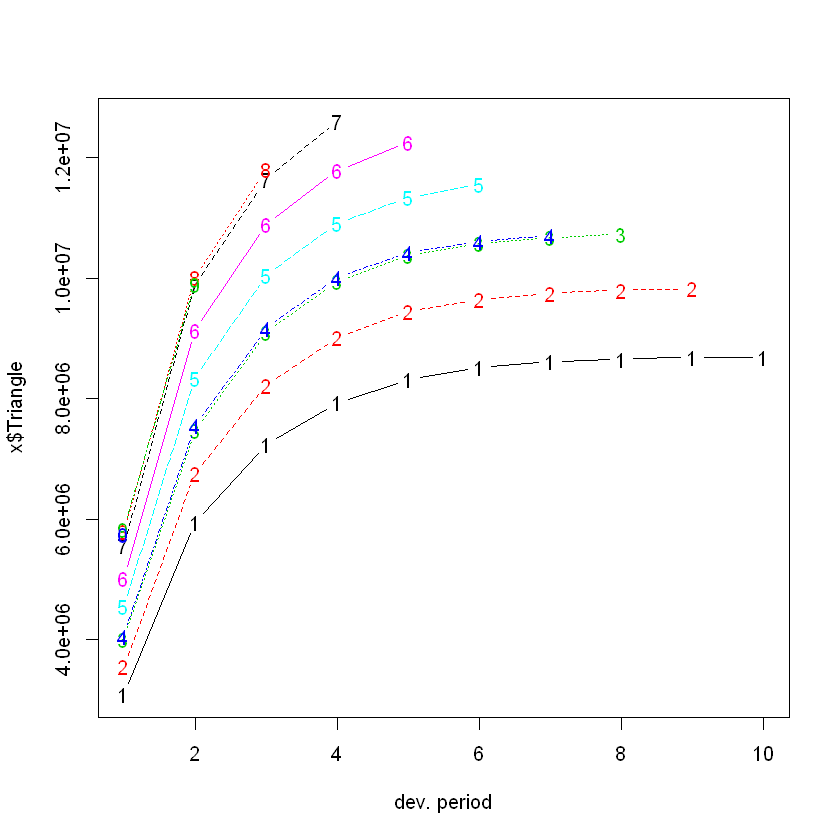

In [30]:
plot(ODP)